# Merging Antarctic Peninsula netcdfs and writing to zarr
This notebook demonstrates how to take a few netcdfs containing RACMO data over the Antarctic Peninsula and merge them together to write a zarr of the whole dataset. The netcdfs:
- each contain one variable for the whole spatial and time domains,
- are stored in 'gs://ldeo-glaciology/RACMO/RACMO_daily_by_var/'
- were put there by Emily Glazer (some details here: https://github.com/ldeo-glaciology/AntPen_NSF_NERC/issues/1)

TLDR: the following code generates the full zarr:
```
gcs = gcsfs.GCSFileSystem()
list_of_NCs = gcs.ls('gs://ldeo-glaciology/RACMO/RACMO_daily_by_var')
list_of_openfiles = [gcs.open(x, mode='rb') for x in list_of_NCs]
list_of_DSs = [xr.open_dataset(x,chunks={}) for x in list_of_openfiles]

merged = xr.merge(list_of_DSs)

filename = 'gs://ldeo-glaciology/RACMO/JK_tests/all_vars_full_1'
mapper = fsspec.get_mapper(filename, mode='w',token=token)
merged.to_zarr(mapper)

merged_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=True, chunks={})
```

In [1]:
import xarray as xr
import gcsfs
import fsspec
import json
import hvplot.xarray

with open('../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

## Try a simple merge
Merge just two data arrays

In [3]:
gcs = gcsfs.GCSFileSystem()
of = gcs.open('gs://ldeo-glaciology/RACMO/RACMO_daily_by_var/RACMO_daily_t2m.nc', mode='rb')
t2m = xr.open_dataset(of,chunks={})

of = gcs.open('gs://ldeo-glaciology/RACMO/RACMO_daily_by_var/RACMO_daily_snowmelt.nc', mode='rb') 
sm = xr.open_dataset(of,chunks={}) 




In [6]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jkingslake/proxy/8787/status,
Dashboard: /user/jkingslake/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37961,Workers: 4
Dashboard: /user/jkingslake/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:46617,Total threads: 1
Dashboard: /user/jkingslake/proxy/34385/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:35961,


In [7]:
sm.nbytes/1e9


13.517262784

In [52]:
merged_small = xr.merge([t2m,sm])

In [53]:
merged_small

<xarray.Dataset>
Dimensions:   (rlon: 501, rlat: 454, time: 14853, height: 1)
Coordinates:
  * rlon      (rlon) float64 -32.0 -31.95 -31.9 -31.85 ... -12.6 -12.55 -12.55
  * rlat      (rlat) float64 -8.7 -8.65 -8.6 -8.55 -8.5 ... 5.9 5.9 5.95 5.95
    lon       (rlat, rlon) float64 dask.array<chunksize=(454, 501), meta=np.ndarray>
    lat       (rlat, rlon) float64 dask.array<chunksize=(454, 501), meta=np.ndarray>
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
  * height    (height) float64 0.0
Data variables:
    t2m       (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    snowmelt  (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>

## Merge all the data vars

In [14]:
list_of_NCs = gcs.ls('gs://ldeo-glaciology/RACMO/RACMO_daily_by_var')
list_of_NCs

['ldeo-glaciology/RACMO/RACMO_daily_by_var/RACMO_daily_precip.nc',
 'ldeo-glaciology/RACMO/RACMO_daily_by_var/RACMO_daily_smb.nc',
 'ldeo-glaciology/RACMO/RACMO_daily_by_var/RACMO_daily_snowfall.nc',
 'ldeo-glaciology/RACMO/RACMO_daily_by_var/RACMO_daily_snowmelt.nc',
 'ldeo-glaciology/RACMO/RACMO_daily_by_var/RACMO_daily_subl.nc',
 'ldeo-glaciology/RACMO/RACMO_daily_by_var/RACMO_daily_t2m.nc',
 'ldeo-glaciology/RACMO/RACMO_daily_by_var/RACMO_daily_tskin.nc']

In [22]:
list_of_openfiles = [gcs.open(x, mode='rb') for x in list_of_NCs]

list_of_DSs = [xr.open_dataset(x,chunks={}) for x in list_of_openfiles]

In [23]:
merged = xr.merge(list_of_DSs)
merged

<xarray.Dataset>
Dimensions:   (rlon: 501, rlat: 454, time: 14853, height: 1)
Coordinates:
  * rlon      (rlon) float64 -32.0 -31.95 -31.9 -31.85 ... -12.6 -12.55 -12.55
  * rlat      (rlat) float64 -8.7 -8.65 -8.6 -8.55 -8.5 ... 5.9 5.9 5.95 5.95
    lon       (rlat, rlon) float64 dask.array<chunksize=(454, 501), meta=np.ndarray>
    lat       (rlat, rlon) float64 dask.array<chunksize=(454, 501), meta=np.ndarray>
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
  * height    (height) float64 0.0
Data variables:
    precip    (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    smb       (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    snowfall  (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    snowmelt  (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    subl      (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    t2m       (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    tskin     (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>

## Try writing just a small part of the merged ds

In [40]:
for var_name in merged.data_vars.keys():
    print(merged[var_name].chunks)

((2476, 2476, 2476, 2476, 2476, 2473), (1,), (76, 76, 76, 76, 76, 74), (84, 84, 84, 84, 84, 81))
((2476, 2476, 2476, 2476, 2476, 2473), (1,), (76, 76, 76, 76, 76, 74), (84, 84, 84, 84, 84, 81))
((2476, 2476, 2476, 2476, 2476, 2473), (1,), (76, 76, 76, 76, 76, 74), (84, 84, 84, 84, 84, 81))
((2476, 2476, 2476, 2476, 2476, 2473), (1,), (76, 76, 76, 76, 76, 74), (84, 84, 84, 84, 84, 81))
((2476, 2476, 2476, 2476, 2476, 2473), (1,), (76, 76, 76, 76, 76, 74), (84, 84, 84, 84, 84, 81))
((2476, 2476, 2476, 2476, 2476, 2473), (1,), (76, 76, 76, 76, 76, 74), (84, 84, 84, 84, 84, 81))
((2476, 2476, 2476, 2476, 2476, 2473), (1,), (76, 76, 76, 76, 76, 74), (84, 84, 84, 84, 84, 81))


In [48]:
merged_one_chunk = merged.isel(time=slice(0,2475), rlat=slice(0,76), rlon=slice(0,84))
merged_one_chunk.nbytes/1e6

442.534432

In [49]:
filename = 'gs://ldeo-glaciology/RACMO/JK_tests/all_vars_1_chunk'
mapper = fsspec.get_mapper(filename, mode='w',token=token)
merged_one_chunk.to_zarr(mapper)

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 38.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [51]:
merged_one_chunk_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=True, chunks={}) 
merged_one_chunk_reloaded.load()
merged_one_chunk_reloaded

<xarray.Dataset>
Dimensions:   (height: 1, rlat: 76, rlon: 84, time: 2475)
Coordinates:
  * height    (height) float64 0.0
    lat       (rlat, rlon) float64 -56.96 -57.01 -57.06 ... -61.56 -61.61 -61.65
    lon       (rlat, rlon) float64 -76.11 -76.13 -76.15 ... -71.61 -71.63 -71.65
  * rlat      (rlat) float64 -8.7 -8.65 -8.6 -8.55 -8.5 ... -5.6 -5.6 -5.55 -5.5
  * rlon      (rlon) float64 -32.0 -31.95 -31.9 -31.85 ... -27.95 -27.9 -27.85
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1985-10-10
Data variables:
    precip    (time, height, rlat, rlon) float32 2.441e-06 2.532e-06 ... nan nan
    smb       (time, height, rlat, rlon) float32 1.656e-09 1.656e-09 ... nan nan
    snowfall  (time, height, rlat, rlon) float32 0.0 0.0 0.0 0.0 ... nan nan nan
    snowmelt  (time, height, rlat, rlon) float32 -2.37e-08 -2.37e-08 ... nan nan
    subl      (time, height, rlat, rlon) float32 3.661e-08 3.661e-08 ... nan nan
    t2m       (time, height, rlat, rlon) float32 279.4 279.4 279.4 ... nan nan
    tskin     (time, height, rlat, rlon) float32 280.1 280.1 280.0 ... nan nan

## Try writing the whole thing

In [54]:
filename = 'gs://ldeo-glaciology/RACMO/JK_tests/all_vars_full_1'
mapper = fsspec.get_mapper(filename, mode='w',token=token)
merged.to_zarr(mapper)

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 39.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [55]:
merged_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=True, chunks={}) 
merged_reloaded

<xarray.Dataset>
Dimensions:   (height: 1, rlat: 454, rlon: 501, time: 14853)
Coordinates:
  * height    (height) float64 0.0
    lat       (rlat, rlon) float64 dask.array<chunksize=(454, 501), meta=np.ndarray>
    lon       (rlat, rlon) float64 dask.array<chunksize=(454, 501), meta=np.ndarray>
  * rlat      (rlat) float64 -8.7 -8.65 -8.6 -8.55 -8.5 ... 5.9 5.9 5.95 5.95
  * rlon      (rlon) float64 -32.0 -31.95 -31.9 -31.85 ... -12.6 -12.55 -12.55
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    precip    (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    smb       (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    snowfall  (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    snowmelt  (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    subl      (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    t2m       (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>
    tskin     (time, height, rlat, rlon) float32 dask.array<chunksize=(2476, 1, 76, 84), meta=np.ndarray>

In [56]:
merged_reloaded.nbytes/1e9

94.598245072

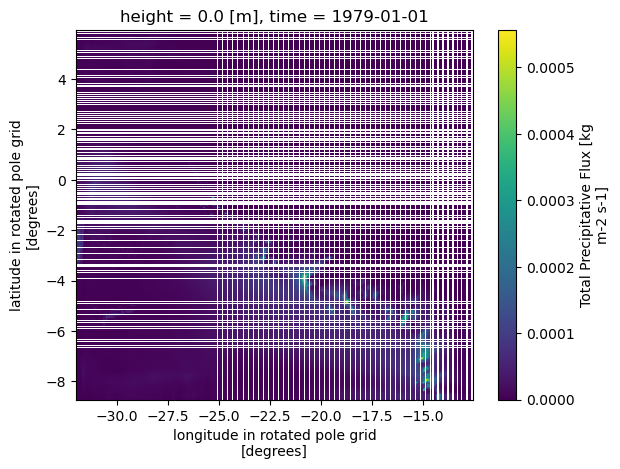

In [62]:
merged_reloaded.precip.isel(time=0, height=0).plot()

In [68]:
merged_reloaded.t2m.nbytes/1e9

13.513497048

In [74]:
%%time 
# this took 14s on the 32GB leap pangeo instance
merged_reloaded.t2m.mean().load()

CPU times: user 1.18 s, sys: 113 ms, total: 1.29 s
Wall time: 13.3 s


<xarray.DataArray 't2m' ()>
array(265.2127, dtype=float32)